In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# !pip install --upgrade k3d

In [3]:
# !pip install msgpack

In [4]:
from collections import defaultdict
from copy import deepcopy
import json
import os
import warnings
from io import BytesIO

import igl
import randomcolor
import trimesh
import k3d
import yaml
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm, trange
from joblib import Parallel, delayed

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-4csoy9mt because the default path (/home/user/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [5]:
from sharpf.utils.abc_utils.hdf5.dataset import Hdf5File, PreloadTypes
import sharpf.utils.abc_utils.hdf5.io_struct as io_struct
import sharpf.data.datasets.sharpf_io as sharpf_io
from sharpf.utils.plotting import display_depth_sharpness
from sharpf.utils.abc_utils.mesh.indexing import reindex_zerobased
from sharpf.utils.abc_utils.mesh.io import trimesh_load


In [282]:
def display_sharpness(mesh=None, plot_meshvert=True,
                      samples=None, samples_distances=None,
                      sharp_vert=None, sharp_curves=None,
                      directions=None, directions_width=0.0025,
                      samples_color=0x0000ff, samples_psize=0.002, 
                      mesh_color=0xbbbbbb, meshvert_color=0x666666, meshvert_psize=0.0025,
                      sharpvert_color=0xff0000, sharpvert_psize=0.0025,
                      sharpcurve_color=None, sharpcurve_width=0.0025,
                      as_image=False, plot_height=768,
                      cmap=k3d.colormaps.matplotlib_color_maps.coolwarm_r, 
                      plot=None, display=True,
                     max_distance_to_feature=1.0):
    
    if None is plot:
        plot = k3d.plot(height=plot_height, camera_auto_fit=False)
    
    if None is not mesh:
        k3d_mesh = k3d.mesh(mesh.vertices, mesh.faces, color=mesh_color)
        plot += k3d_mesh

        if plot_meshvert:
            k3d_points = k3d.points(mesh.vertices, 
                                    point_size=meshvert_psize, color=meshvert_color)
            plot += k3d_points
            k3d_points.shader='flat'

    if None is not samples:
        colors = None
        if None is not samples_distances and not np.all(samples_distances == 1.0):
            colors = k3d.helpers.map_colors(
                samples_distances, cmap, [0, max_distance_to_feature]
            ).astype(np.uint32)
            k3d_points = k3d.points(samples, point_size=samples_psize, colors=colors)
        else:
            v = -np.array([0., 1., 0.])
            max_dist = np.max(np.dot(samples, v))
            min_dist = np.min(np.dot(samples, v))
            colors = k3d.helpers.map_colors(
                np.dot(samples, v), k3d.colormaps.matplotlib_color_maps.viridis, [min_dist, max_dist]
            ).astype(np.uint32)
            k3d_points = k3d.points(samples, point_size=samples_psize, colors=colors)

        plot += k3d_points
        k3d_points.shader='flat'
        
        if None is not directions:
            vectors = k3d.vectors(
                samples,
                directions * samples_distances[..., np.newaxis],
                use_head=False, 
                line_width=directions_width)
            print(vectors)
            plot += vectors

#             directions_to_plot = np.hstack((samples, samples + directions))
            
#             for i, dir_to_plot in enumerate(directions_to_plot):
#                 dir_to_plot = dir_to_plot.reshape((2, 3))
#                 if np.all(dir_to_plot[0] == dir_to_plot[1]):
#                     continue
#                 color = int(colors[i]) if None is not colors else samples_color
#                 plt_line = k3d.line(dir_to_plot, 
#                                     shader='mesh', width=directions_width, color=color)
#                 plot += plt_line

    if None is not sharp_vert:
        k3d_points = k3d.points(sharp_vert,
                                point_size=sharpvert_psize, color=sharpvert_color)
        plot += k3d_points
        k3d_points.shader='flat'
        
        if None is not sharp_curves:            
            if None is not sharpcurve_color:
                color = sharpcurve_color
            else:
                import randomcolor
                rand_color = randomcolor.RandomColor()
            for i, vert_ind in enumerate(sharp_curves):
                sharp_points_curve = mesh.vertices[vert_ind]
                
                if None is sharpcurve_color:
                    color = rand_color.generate(hue='red')[0]
                    color = int('0x' + color[1:], 16)
                plt_line = k3d.line(sharp_points_curve, 
                                    shader='mesh', width=sharpcurve_width, color=color)
                plot += plt_line
        
    plot.grid_visible = False
    if display:
        plot.display()
    
    if as_image:
        plot.fetch_screenshot()
        return Image(data=b64decode(plot.screenshot))
    
    return plot

In [7]:
# mm/pixel
HIGH_RES = 0.02
MED_RES = 0.05
LOW_RES = 0.125
XLOW_RES = 0.25

DISPLAY_RES = 0.02 * 1.5

In [8]:
from sharpf.utils.convertor_utils.convertors_io import ViewIO, RangeVisionIO

def get_mesh(hdf5_filename, obj_mesh):
    dataset = Hdf5File(
        hdf5_filename,
        io=ViewIO,
        preload=PreloadTypes.LAZY,
        labels='*')

    with open(obj_filename, 'rb') as obj_file:
        obj_mesh, _, _ = trimesh_load(BytesIO(obj_file.read()))


    obj_alignment_transform = dataset[0]['obj_alignment']
    obj_scale = dataset[0]['obj_scale']
    mesh = obj_mesh.copy() \
        .apply_scale(obj_scale) \
        .apply_transform(obj_alignment_transform)
    
    return mesh

In [9]:
def fuse_points(n_points, list_predictions, list_indexes_in_whole, list_points):
    fused_points = np.zeros((n_points, 3))
    fused_distances = np.ones(n_points) * np.inf
    # fused_directions = np.ones((n_points, 3)) * np.inf

    iterable = zip(list_predictions, list_indexes_in_whole, list_points)
    for distances, indexes, points in tqdm(iterable):
        fused_points[indexes] = points
        assign_mask = fused_distances[indexes] > distances
        fused_distances[indexes[assign_mask]] = np.minimum(distances[assign_mask], 2.5)
        # fused_directions[indexes[assign_mask]] = directions[assign_mask]

    return fused_points, fused_distances, {}

In [10]:
import argparse
from glob import glob
from io import BytesIO
import os
import sys

import igl
import numpy as np
import trimesh.transformations as tt
from tqdm import tqdm
import yaml


from sharpf.data.annotation import ANNOTATOR_BY_TYPE
from sharpf.utils.camera_utils.view import CameraView
from sharpf.data.imaging import RaycastingImaging
from sharpf.utils.py_utils.config import load_func_from_config
from sharpf.utils.camera_utils.camera_pose import CameraPose, camera_to_display
from sharpf.utils.abc_utils.hdf5.dataset import Hdf5File, PreloadTypes
from sharpf.utils.abc_utils.mesh.io import trimesh_load
from sharpf.utils.convertor_utils.convertors_io import (
    AnnotatedViewIO,
    ViewIO,
    write_annotated_views_to_hdf5)
from sharpf.utils.abc_utils.abc.feature_utils import (
    compute_features_nbhood,
    remove_boundary_features,
    submesh_from_hit_surfaces)
from sharpf.utils.convertor_utils.meshlab_project_parsers import load_meshlab_project
import sharpf.utils.convertor_utils.rangevision_utils as rv_utils
from sharpf.utils.camera_utils import matrix


In [11]:
def illustrate_camera(
    camera_pose: CameraPose,
    l=1.0,
    w=1.0,
    use_head=False,
    hs=1.0,
):
    camera_center = np.array([
        camera_pose.frame_origin,
        camera_pose.frame_origin,
        camera_pose.frame_origin])

    camera_frame = np.array([
        camera_pose.frame_axes
    ]) * l
    
    x_color = 0xff0000
    y_color = 0x00ff00
    z_color = 0x0000ff

    vectors = k3d.vectors(
        camera_center,
        camera_frame,
        use_head=use_head, 
        head_size=hs,
        line_width=w,
        colors=[x_color, x_color, y_color, y_color, z_color, z_color],)

    return vectors

In [12]:
def get_random_color(hue=None):
    rand_color = randomcolor.RandomColor()
    color = rand_color.generate(hue=hue)[0]
    color = int('0x' + color[1:], 16)
    return color

In [13]:
def plot_alignment_quality(views, mesh):

    distances = np.concatenate(
        [np.sqrt(igl.point_mesh_squared_distance(
            view.depth, mesh.vertices, mesh.faces)[0])
        for view in views])

    plt.figure(figsize=(12, 6))
    _ = plt.hist(distances, bins=100, range=[0, 10])
    plt.gca().set_yscale('log')
    plt.gca().set_ylim([0, 1e5])
    plt.gca().set_xlim([0, 10])
    plt.gca().set_xlabel('Distance to ground truth CAD model, mm', fontsize=14)
    plt.gca().set_ylabel('Number of point samples', fontsize=14)
    plt.gca().tick_params(axis='both', which='major', labelsize=14)
    plt.gca().tick_params(axis='both', which='minor', labelsize=14)
    
    for q in [0.5, 0.95, 0.99]:
        q_val = np.quantile(distances, q)
        label = '{0:3.0f}%: {1:0.2f}'.format(q * 100, q_val)
        plt.axvline(q_val, 0, 1e5, 
                    color=plt.get_cmap('rainbow')(q), linewidth=3, 
                    label=label)
        print(label)
    plt.legend(fontsize=16, loc='upper right')

In [14]:
def transform_to_frame(matrix, frame):
    """Given a transform defined by its matrix in a particular coordinate frame,
    compute its matrix under a given coordinate frame transformation.
    
    Parameters
    -------------
    matrix : (4, 4) float
      Homogeneous transform matrix
      
    frame : (4, 4) float
      Homogeneous coordinate frame transformation matrix

    Returns
    --------------
    transformed_matrix : (4, 4) float
      Homogeneous transform matrix for a given frame 
    """
    matrix = np.asanyarray(matrix, dtype=np.float64)
    frame = np.asanyarray(frame, dtype=np.float64)

    return frame @ matrix @ np.linalg.inv(frame)
    

In [15]:
def plot_views(
    views_iterable,
    obj_mesh,
):
    views = [
        CameraView(
            depth=tt.transform_points(
                scan['points'].reshape((-1, 3)), 
                scan['points_alignment']),
            signal=None,
            faces=scan['faces'].reshape((-1, 3)),
            extrinsics=np.dot(scan['points_alignment'], scan['extrinsics']),
            intrinsics=scan['intrinsics'],
            state='points')
        for scan in tqdm(views_iterable, desc='Loading scans')]


    plot = k3d.plot(grid_visible=True, height=768)

    for view in views:
        scan_mesh = trimesh.base.Trimesh(
            view.depth, 
            view.faces, 
            process=False, 
            validate=False)

        plot += k3d.points(
            scan_mesh.vertices,
            point_size=0.25,
            color=get_random_color(hue='green'),
            shader='flat')

    obj_scale = views_iterable[0]['obj_scale']
    obj_alignment = views_iterable[0]['obj_alignment']
    mesh = obj_mesh.copy().apply_scale(obj_scale).apply_transform(obj_alignment)
    plot += k3d.mesh(
        mesh.vertices, 
        mesh.faces, 
        color=0xaaaaaa,
        flat_shading=False)

    plot.display()
    
    return views, mesh

In [17]:
input_dir = '/logs/images_fused'

In [47]:
predictions_filename = os.path.join(input_dir, '16top_folder_images__predictions.hdf5')
gt_filename = '/logs/images/16top_folder_images.hdf5'

In [48]:
ground_truth_dataset = Hdf5File(
    gt_filename,
    io=AnnotatedViewIO,
    preload=PreloadTypes.LAZY,
    labels='*')
views = [
    CameraView(
        depth=scan['points'],
        signal=scan['distances'],
        faces=scan['faces'].reshape((-1, 3)),
        extrinsics=np.dot(scan['points_alignment'], scan['extrinsics']),
        intrinsics=scan['intrinsics'],
        state='pixels')
    for scan in ground_truth_dataset]
view_alignments = [scan['points_alignment'] for scan in ground_truth_dataset]

predictions_dataset = Hdf5File(
    predictions_filename,
    io=sharpf_io.WholeDepthMapIO,
    preload=PreloadTypes.LAZY,
    labels='*')
list_predictions = [patch['distances'] for patch in predictions_dataset]

File /logs/images_fused/16top_folder_images__predictions.hdf5 is not compatible with Hdf5File I/O interface <class 'sharpf.utils.abc_utils.hdf5.io_struct.HDF5IO'>
File /logs/images_fused/16top_folder_images__predictions.hdf5 is not compatible with Hdf5File I/O interface <class 'sharpf.utils.abc_utils.hdf5.io_struct.HDF5IO'>


In [61]:
def clip_to_depth(signal, depth, depth_value=1.0):
    img = signal.copy()
    img[depth == depth_value] = 0.
    return img

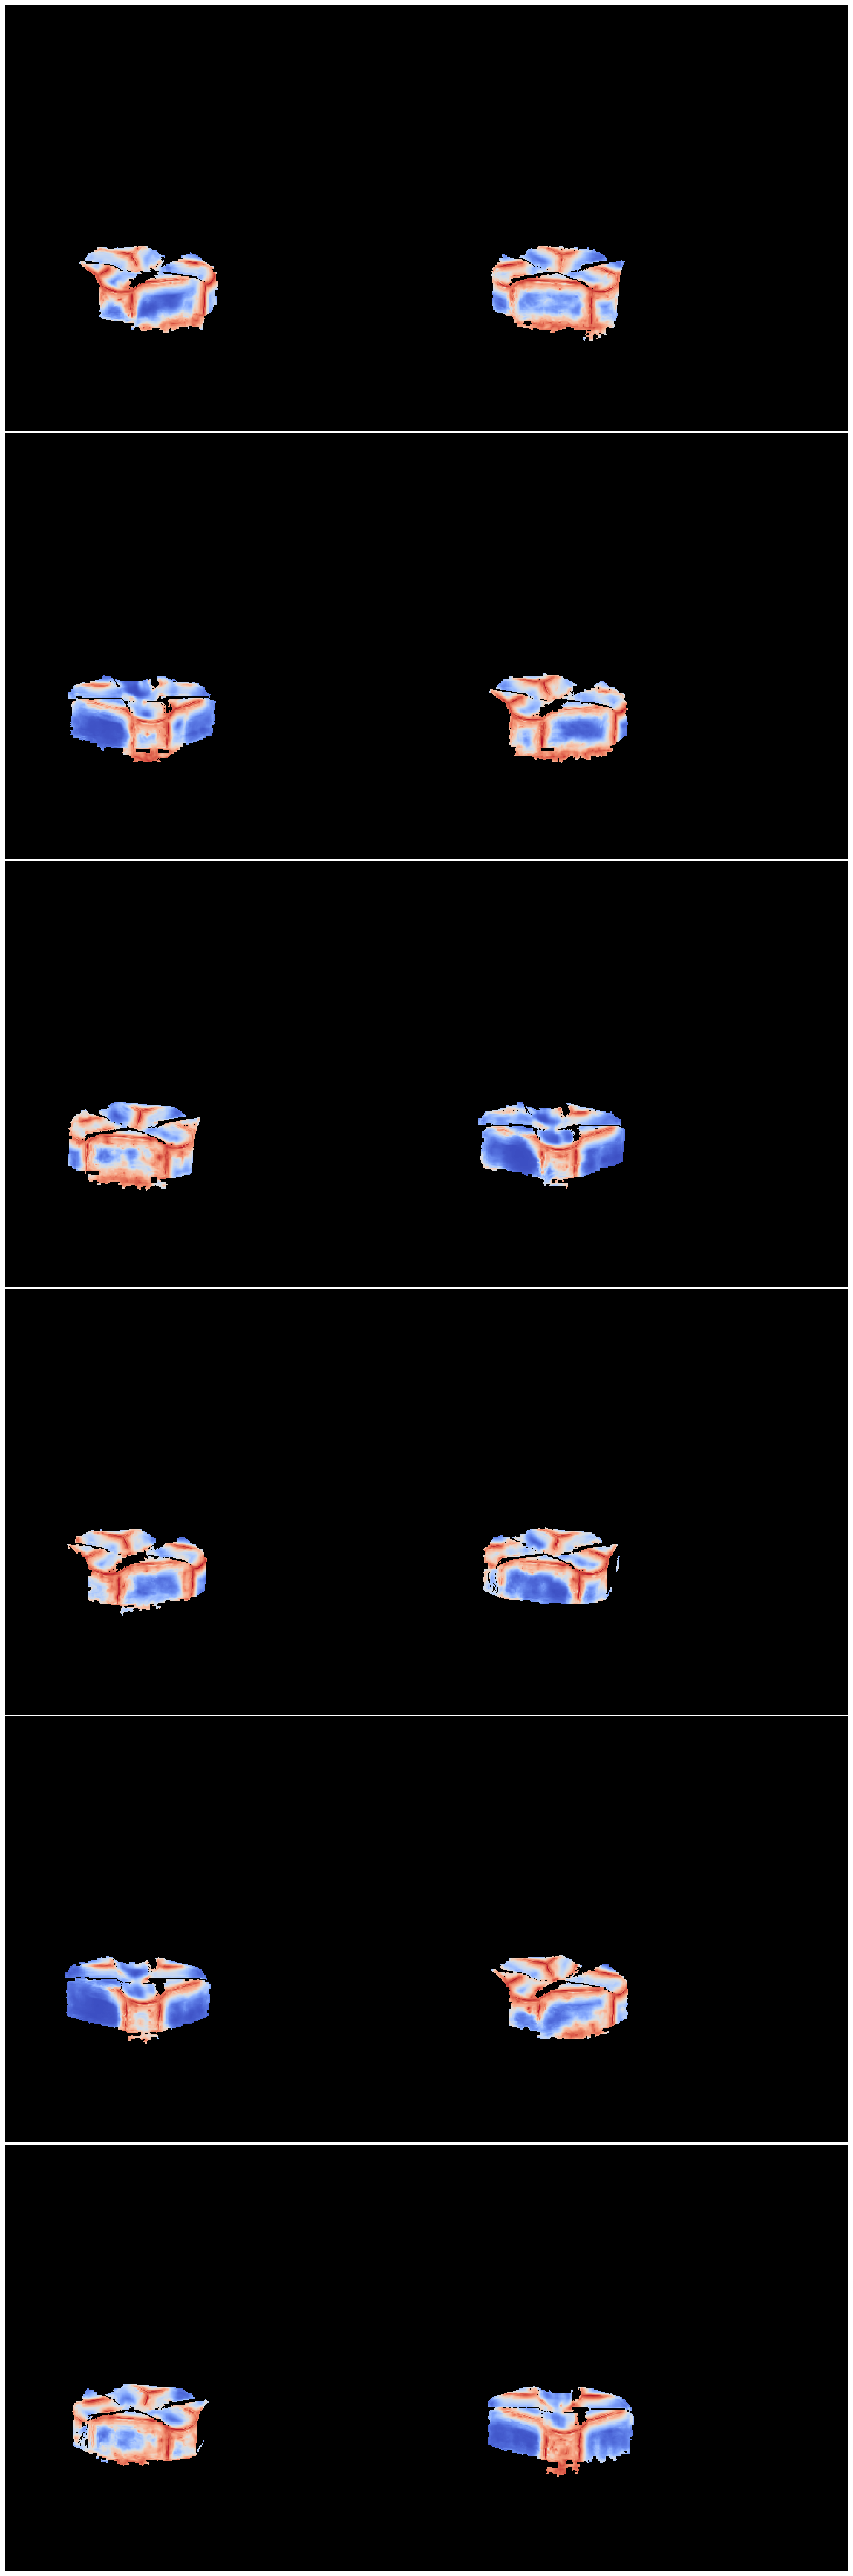

In [62]:
rx, ry = rv_utils.RV_SPECTRUM_CAM_RESOLUTION
sx, sy = 512, 512
slices = slice(ry // 2 - sy // 2, ry // 2 + sy // 2),\
         slice(rx // 2 - sx // 2, rx // 2 + sx // 2)
sharpness_images_for_display = [
    clip_to_depth(distances[slices], view.to_pixels().depth[slices], depth_value=0.0) 
    for distances, view in zip(list_predictions, views)]


display_depth_sharpness(
    depth_images=None,
    sharpness_images=sharpness_images_for_display,
    ncols=2,
    axes_size=(16, 3*16),
    max_sharpness=1.0)

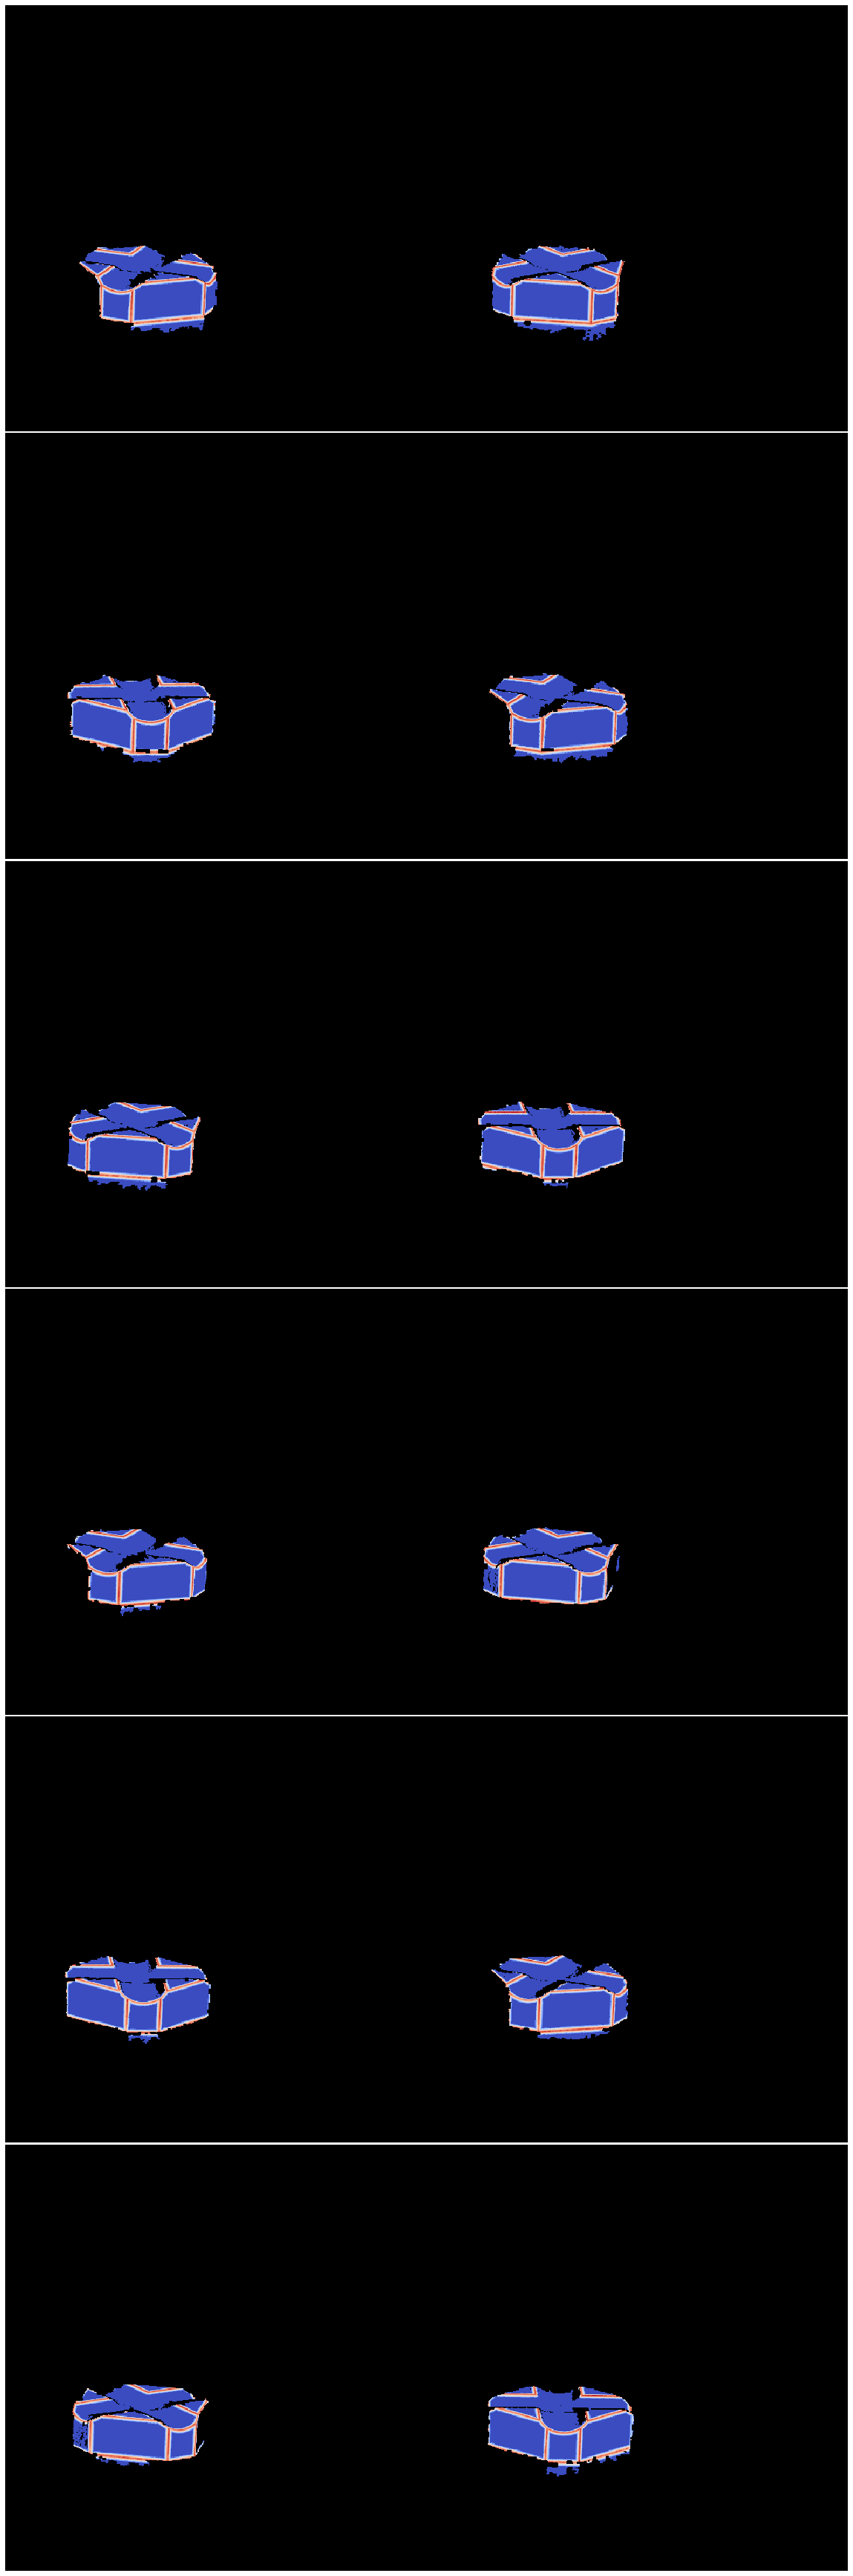

In [59]:
rx, ry = rv_utils.RV_SPECTRUM_CAM_RESOLUTION
sx, sy = 512, 512
slices = slice(ry // 2 - sy // 2, ry // 2 + sy // 2),\
         slice(rx // 2 - sx // 2, rx // 2 + sx // 2)
sharpness_images_for_display = [view.to_pixels().signal[slices] for view in views]


display_depth_sharpness(
    depth_images=None,
    sharpness_images=sharpness_images_for_display,
    ncols=2,
    axes_size=(16, 3*16),
    max_sharpness=2.5)

In [123]:
views_predicted = [view.copy() for view in views]
views_predicted = [view.to_pixels() for view in views_predicted]

for distances, view in zip(list_predictions, views_predicted):
    view.signal = distances

In [167]:
target_view_r.to_points().depth.min()

-145.08057026064432

In [186]:
source_view = views_predicted[0].copy()
target_view = views_predicted[2].copy()

In [187]:
source_view = source_view.to_image()
target_view_r = target_view.reproject_to(source_view)

In [188]:
from sharpf.fusion.images import interpolate


target_signal, valid_mask = interpolate.pointwise_interpolate_image(
    source_view.depth,
    source_view.signal,
    target_view_r.depth,
    distance_interp_thr='auto',
    nn_set_size=8,
    z_distance_threshold=4.0,
    verbose=False)

Interpolating: 100%|██████████| 8914/8914 [00:01<00:00, 6081.45it/s]


In [189]:
target_view_i = target_view_r.copy()
target_view_i.signal = target_signal

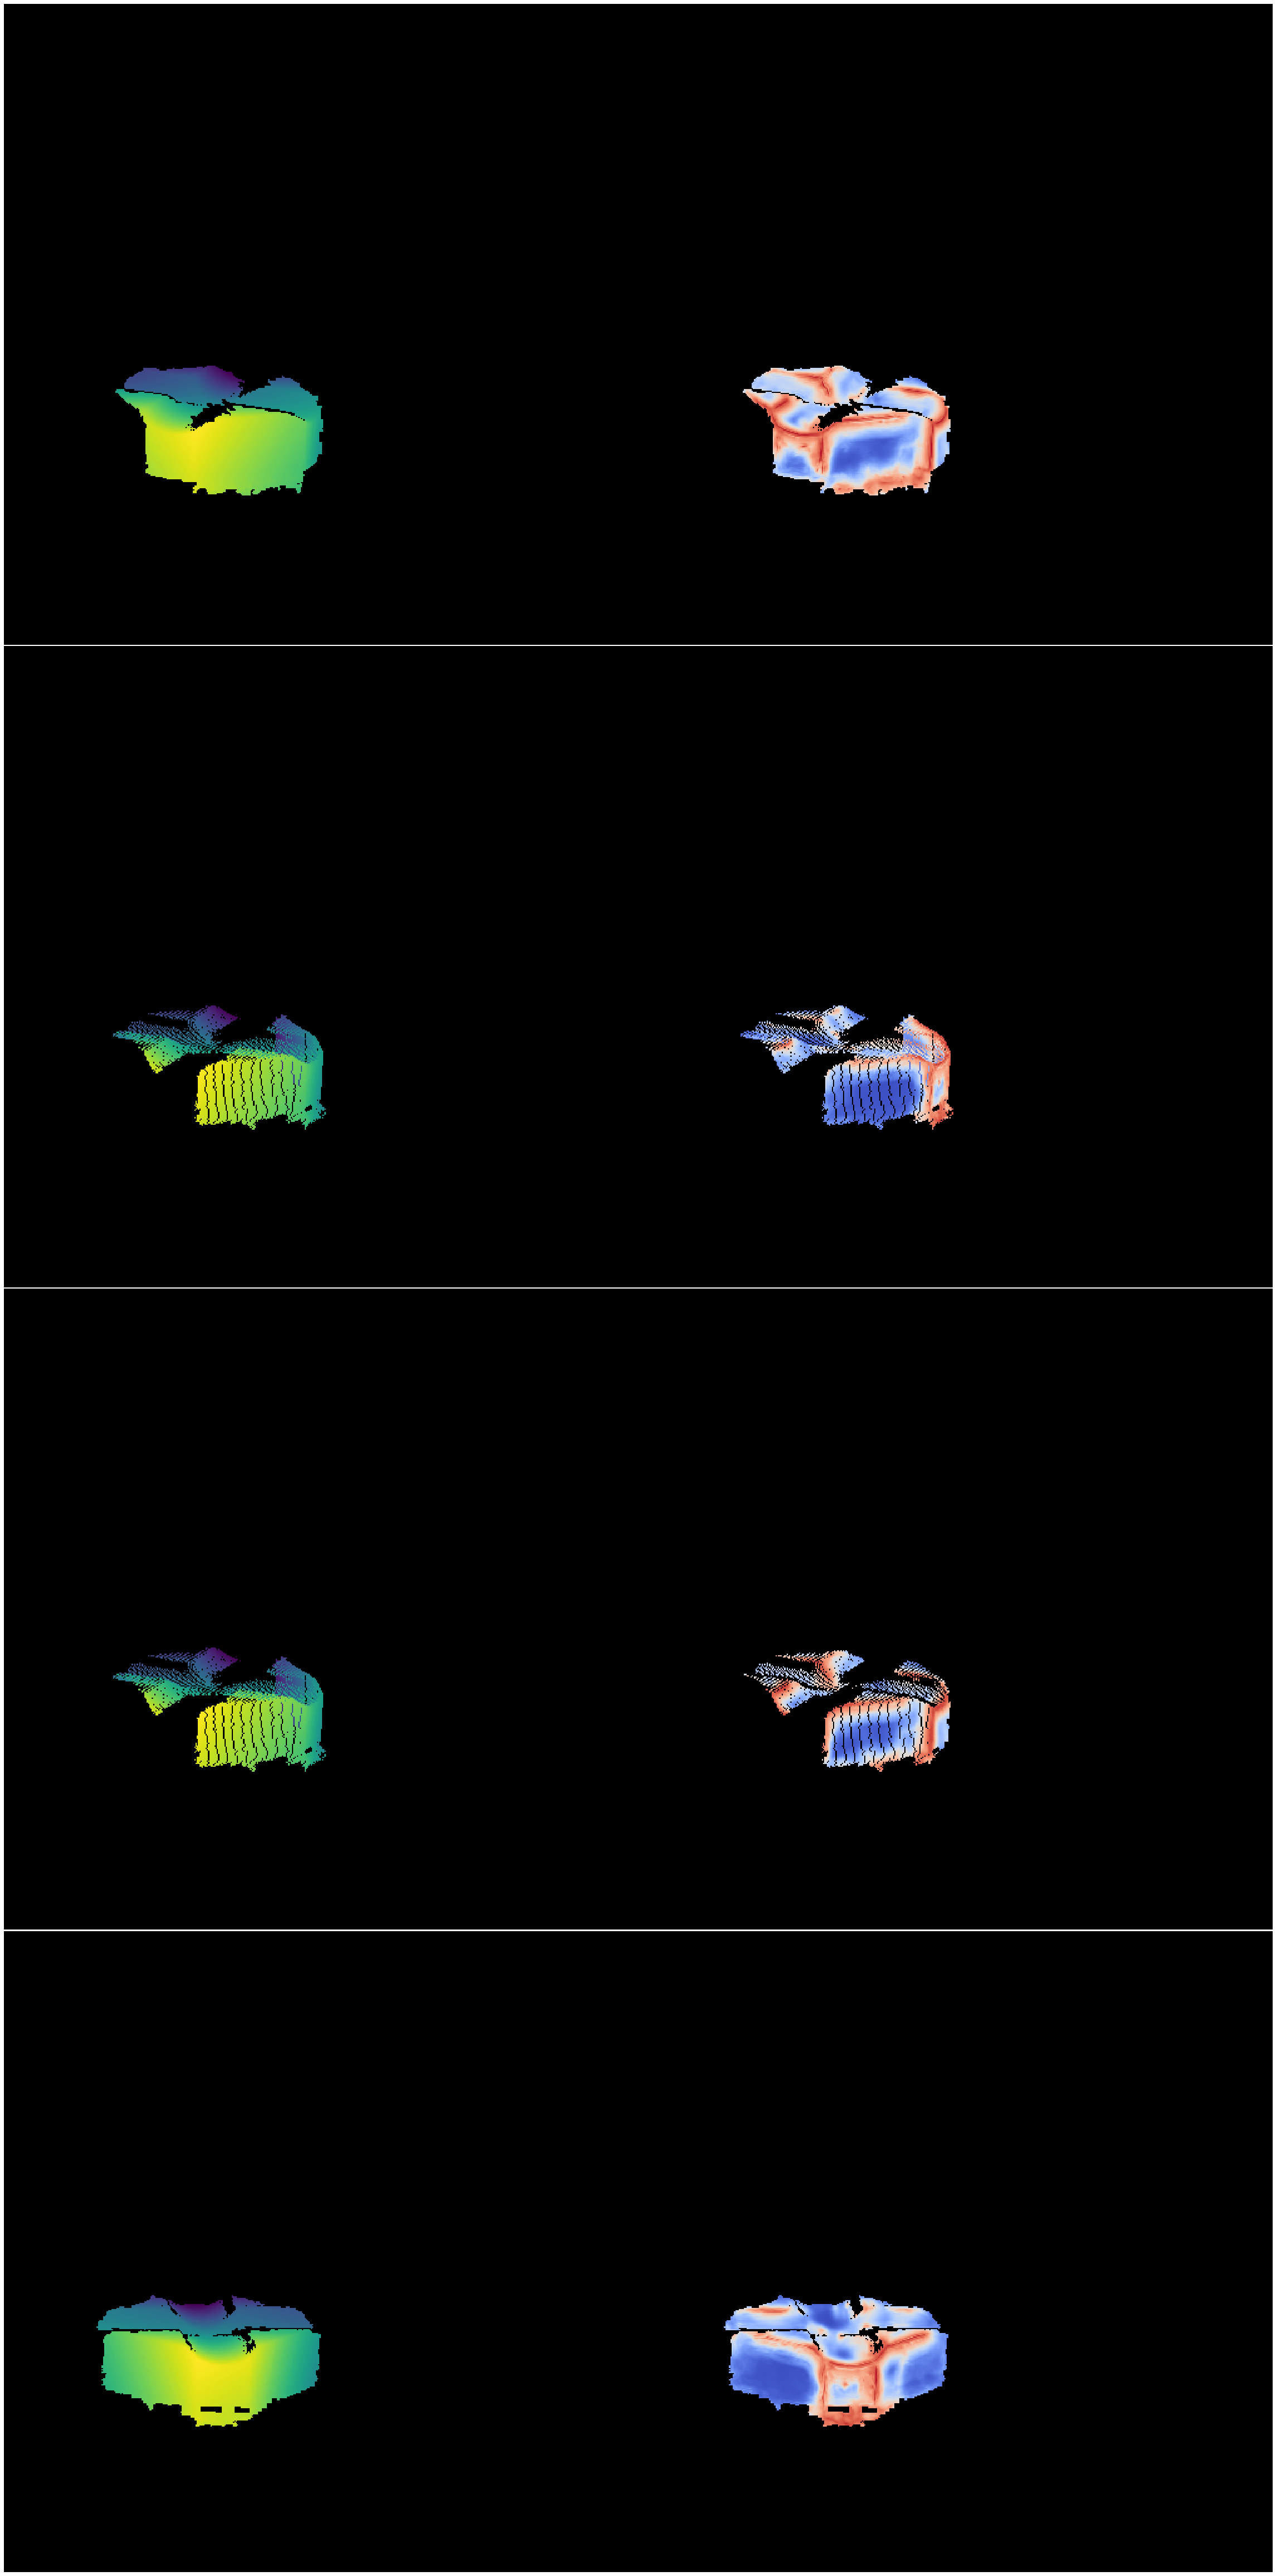

In [190]:
rx, ry = rv_utils.RV_SPECTRUM_CAM_RESOLUTION
sx, sy = 512, 512
slices = slice(ry // 2 - sy // 2, ry // 2 + sy // 2),\
         slice(rx // 2 - sx // 2, rx // 2 + sx // 2)

v1 = source_view.to_pixels()
v2r = target_view_r.to_pixels()
v2i = target_view_i.to_pixels()
v2 = target_view.to_pixels()

depth_images_for_display = [
    v1.depth[slices],
    v2r.depth[slices],
    v2i.depth[slices],
    v2.depth[slices],
]
sharpness_images_for_display = [
    clip_to_depth(v1.signal[slices], v1.depth[slices], depth_value=0.0),
    clip_to_depth(v2r.signal[slices], v2r.depth[slices], depth_value=0.0),
    clip_to_depth(v2i.signal[slices], v2i.depth[slices], depth_value=0.0),
    clip_to_depth(v2.signal[slices], v2.depth[slices], depth_value=0.0),
]
display_depth_sharpness(
    depth_images=depth_images_for_display,
    sharpness_images=sharpness_images_for_display,
    ncols=1,
    axes_size=(16, 16),
    max_sharpness=1.0)

In [213]:
from sharpf.fusion.images.interpolators import MVS_INTERPOLATORS, GroundTruthInterpolator
import sharpf.fusion.combiners as combiners

In [289]:
config = {
    'type': 'image',
    'verbose': False,
    'n_jobs': 16,
    'distance_interpolation_threshold': 'auto',
    'nn_set_size': 8,
    'z_distance_threshold': 2.0,
}

mvs_interpolator = load_func_from_config(MVS_INTERPOLATORS, config)

list_predictions, list_indexes_in_whole, list_points = mvs_interpolator(views_predicted)

# combiner = combiners.TruncatedAvgPredictionsCombiner(
#             func=combiners.TruncatedMean(0.6, func=np.min))

combiner = combiners.MinPredictionsCombiner()

n_points = np.max(np.concatenate(list_indexes_in_whole)) + 1
fused_points_pred, fused_distances_pred, _ = combiner(
    n_points,
    list_predictions,
    list_indexes_in_whole,
    list_points,
    max_distance=2.5)

{'image': <class 'sharpf.fusion.images.interpolators.MultiViewImage'>} {'type': 'image', 'verbose': False, 'n_jobs': 16, 'distance_interpolation_threshold': 'auto', 'nn_set_size': 8, 'z_distance_threshold': 2.0}


Interpolating: 100%|██████████| 3881/3881 [00:00<00:00, 4173.40it/s]


Interpolating: 100%|██████████| 10259/10259 [00:01<00:00, 5660.58it/s]
144it [00:00, 282.71it/s]


In [290]:
list_predictions_, list_indexes_in_whole_, list_points_ = GroundTruthInterpolator()(views)
n_points = np.sum([len(points) for points in list_points_])
fused_points_gt, fused_distances_gt, prediction_variants_gt = combiners.GroundTruthCombiner()(
    n_points,
    list_predictions_,
    list_indexes_in_whole_,
    list_points_,
    max_distance=2.5)

12it [00:00, 2911.87it/s]


In [291]:
np.linalg.norm(fused_distances_gt - fused_distances_pred)

717.2207271043557

In [295]:
# idx = 4
# display_sharpness(
#     samples=np.concatenate((list_points[0], list_points[idx])),
#     samples_distances=np.concatenate((list_predictions[0], list_predictions[idx])),
#     samples_psize=0.5
# )

display_sharpness(
    samples=fused_points_pred,
    samples_distances=fused_distances_pred,
    samples_psize=0.5,
    max_distance_to_feature=0.5
)

Output()

Plot(antialias=3, axes=['x', 'y', 'z'], axes_helper=1.0, background_color=16777215, camera=[2, -3, 0.2, 0.0, 0…